# How many zero and low emissions vehicles are registered in California?

### Load Python tools

In [7]:
%load_ext lab_black

In [148]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_stiles as altstiles
import numpy as np
import jenkspy
import matplotlib
import matplotlib.pyplot as plt
from pywaffle import Waffle

In [9]:
alt.themes.register("stiles", altstiles.theme)
alt.themes.enable("stiles")

ThemeRegistry.enable('grid')

In [10]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [11]:
today = pd.to_datetime("today").strftime("%Y-%m-%d")

### Read data from California Department of Motor Vehicles - current as of Jan. 1, 2021

In [12]:
# https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
url = "https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/resource/888bbb6c-09b4-469c-82e6-1b2a47439736/download/vehicle-fuel-type-count-by-zip-code-2021.csv"

In [13]:
src = pd.read_csv(url, low_memory=False)

### Clean up field names

In [14]:
src.columns = (
    src.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

In [15]:
src.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [16]:
"{:,.0f}".format(src.vehicles.sum())

'29,599,519'

In [28]:
src.model_year.value_counts()

<2008    97973
2017     53043
2016     50815
2015     50404
2019     50185
2018     49670
2014     46972
2013     46144
2012     42860
2020     41257
2011     38397
2008     36613
2010     31589
2009     28101
2021     13946
Name: model_year, dtype: int64

### Remove older vehicles

In [18]:
vehicles = src[src["model_year"] != "<2008"]

In [19]:
"{:,.0f}".format(vehicles.vehicles.sum())

'19,369,518'

### How many don't rely solely on gasoline?

In [20]:
nogas = vehicles[(vehicles["fuel"] != "Gasoline")]

In [21]:
zev = vehicles[vehicles["fuel"] == "Battery Electric"]

In [22]:
cvrp = vehicles[
    (vehicles["fuel"] == "Battery Electric")
    | (vehicles["fuel"] == "Hydrogen Fuel Cell")
    | (vehicles["fuel"] == "Plug-in Hybrid")
]

In [23]:
"{:,.0f}".format(nogas.vehicles.sum())

'3,495,343'

### How many are battery electric, or otherwise CVRP eligible?

In [24]:
"{:,.0f}".format(cvrp.vehicles.sum())

'646,343'

In [25]:
"{:,.0f}".format(zev.vehicles.sum())

'374,760'

### Share of newer CA vehicles that don't rely solely on gas?

In [26]:
"{:,.1f}%".format((nogas.vehicles.sum() / vehicles.vehicles.sum()) * 100)

'18.0%'

### Share of CA vehicles that are battery electric, or otherwise CVRP eligible?

In [27]:
"{:,.1f}%".format((cvrp.vehicles.sum() / vehicles.vehicles.sum()) * 100)

'3.3%'

---

### ZIP codes points

In [29]:
zips_point = gpd.read_file("../../../data/gis/zipcodes.geojson")

In [30]:
zips_point["zip"] = zips_point["zip"].astype(str)

In [31]:
ca_zips_point = zips_point[zips_point["state"] == "CA"]

### ZIP codes boundaries

In [33]:
# Filtered CA from this national file maintained by Esri:
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file("../../../data/gis/ca-zip-codes-esri.geojson")
zips_poly = gpd.read_file("../../../data/gis/ca-zip-codes-esri-demographics.geojson")

In [34]:
zips_poly.columns = (
    zips_poly.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

In [35]:
zips_poly.dropna(inplace=True)

In [36]:
zips_poly.rename(columns={"zip_code": "zip"}, inplace=True)

In [37]:
zips_poly.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.0,2.42,2925,7671,2.98,12304,5.9,"POLYGON ((-122.27703 37.53436, -122.27687 37.5..."
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.6,2.43,4798,12179,3.06,20020,13.0,"POLYGON ((-122.37728 37.60562, -122.37738 37.6..."
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.9,2.09,593,2749,2.70,6609,43.2,"POLYGON ((-120.77255 35.46196, -120.77270 35.4..."
3,4901,93445,Oceano,7633,4683,60,114,155,7,3389,1477,283,34.7,2.86,541,1582,3.42,2871,2.0,"POLYGON ((-120.63624 35.12213, -120.63591 35.1..."
4,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.0,3.10,4637,13991,3.54,20103,5.7,"POLYGON ((-122.50283 37.70813, -122.50242 37.7..."


---

### ZIP codes demographics from mapping giant Esri

In [38]:
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/WealthiestZipCodes2017/FeatureServer/0/
zips_wealth = gpd.read_file("../../../data/gis/WealthiestZipCodesCA.geojson")

In [39]:
zips_wealth.head()

,OBJECTID,ID,NAME,ST_ABBREV,HAI_CY,INCMORT_CY,WLTHRNK_CY,DOMSTATE,DOMCOUNTY,COUNTY_NAME,DOMCBSA,CBSA_NAME,TOTPOP_CY,TOTHH_CY,MEDAGE_CY,AVGHINC_CY,AVGVAL_CY,AVGNW_CY,Shape__Area,Shape__Length,geometry
0,29014,90001,Los Angeles,CA,55,44.1,27675.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",59907,13454,27.1,46931,377591,82915,1.274793e+07,17936.346667,"POLYGON ((-118.24754 33.98908, -118.24776 33.9..."
1,29015,90002,Los Angeles,CA,59,41.2,27690.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",53573,12115,26.7,46332,331694,96786,1.134827e+07,16650.994848,"POLYGON ((-118.24745 33.96015, -118.25169 33.9..."
2,29016,90003,Los Angeles,CA,52,46.6,28202.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",71967,16771,27.1,43020,358057,66091,1.365974e+07,23821.373485,"MULTIPOLYGON (((-118.28268 33.98926, -118.2826..."
3,29017,90004,Los Angeles,CA,21,114.5,20202.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",63987,23021,35.8,65893,909580,232653,1.090500e+07,22878.233455,"MULTIPOLYGON (((-118.33852 34.06891, -118.3371..."
4,29018,90005,Los Angeles,CA,22,111.5,26028.0,06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",41844,17067,35.8,53191,836569,105569,5.390883e+06,19394.836905,"POLYGON ((-118.31879 34.05514, -118.31861 34.0..."


In [40]:
zips_wealth_slim = zips_wealth[["ID", "NAME", "AVGHINC_CY", "AVGNW_CY", "TOTPOP_CY"]]

In [41]:
zips_esri = zips_wealth_slim.rename(
    columns={
        "ID": "zip",
        "NAME": "name",
        "AVGHINC_CY": "avg_house_income",
        "AVGNW_CY": "avg_net_worth",
        "TOTPOP_CY": "population",
    }
)

In [42]:
zips_esri.head()

,zip,name,avg_house_income,avg_net_worth,population
0,90001,Los Angeles,46931,82915,59907
1,90002,Los Angeles,46332,96786,53573
2,90003,Los Angeles,43020,66091,71967
3,90004,Los Angeles,65893,232653,63987
4,90005,Los Angeles,53191,105569,41844


In [43]:
zips_esri.to_csv("data/processed/zip_demographics.csv", index=False)
vehicles[vehicles["zip"] != "OOS"].to_csv(
    "data/processed/vehicle-count.csv", index=False
)

---

### Group the vehicles and count them by the registration ZIP code

In [44]:
zipcodes = vehicles.groupby(["zip"]).agg({"vehicles": "sum"}).reset_index()

In [45]:
zipcodes.sort_values(by="vehicles", ascending=False).head(10)
zipcodes["zip"] = zipcodes["zip"].astype(str)

### Merge the registration zip codes and merge with Esri zipcode polygons

In [46]:
zips = pd.merge(zips_esri, zipcodes, left_on="zip", right_on="zip")

In [47]:
zips.head()

,zip,name,avg_house_income,avg_net_worth,population,vehicles
0,90001,Los Angeles,46931,82915,59907,17557
1,90002,Los Angeles,46332,96786,53573,16204
2,90003,Los Angeles,43020,66091,71967,21163
3,90004,Los Angeles,65893,232653,63987,21400
4,90005,Los Angeles,53191,105569,41844,11925


---

### Group by duty. Which are most common among ALL vehicles? 

In [48]:
# About 2.5 are listed as OTHER/UNK
duty_totals = vehicles.groupby(["duty"]).agg("sum").reset_index()
duty_totals.head()

,duty,vehicles
0,Heavy,641930
1,Light,17854468
2,Unk,873120


### Group by make. Which are most common? 

In [56]:
# About 2.5 are listed as OTHER/UNK
make = (
    vehicles[vehicles["make"] != "OTHER/UNK"]
    .groupby(["make", "zip"])
    .agg("sum")
    .reset_index()
)

In [57]:
most_make = (
    make.groupby(["make"])
    .agg("sum")
    .reset_index()
    .sort_values(by="vehicles", ascending=False)
)

In [58]:
most_make.head()

,make,vehicles
82,TOYOTA,3395698
30,HONDA,2314599
23,FORD,1503770
60,NISSAN,1276536
17,CHEVROLET,1182738


In [59]:
makelist = most_make.make.to_list()

In [60]:
popular_makes = make[make["make"].isin(makelist)]

In [61]:
make_zip = pd.DataFrame(
    pd.pivot_table(
        popular_makes,
        values="vehicles",
        index=["zip"],
        columns=["make"],
        aggfunc=np.sum,
        fill_value=0,
    ).reset_index()
)

In [62]:
make_zip.columns = (
    make_zip.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

### Which make is most common in each ZIP code? 

In [70]:
make_zip["total"] = make_zip[
    [
        "acura",
        "alexander_dennis",
        "alfa_romeo",
        "allianz",
        "am_general",
        "american_lafrance",
        "audi",
        "autocar",
        "bentley",
        "blue_bird",
        "bluebird",
        "bmw",
        "buick",
        "cadillac",
        "capacity",
        "capacity_of_texas_inc",
        "caterpillar",
        "chevrolet",
        "chrysler",
        "crane_carrier",
        "dodge",
        "evobus",
        "fiat",
        "ford",
        "freightliner",
        "genesis",
        "gillig",
        "gmc",
        "hino",
        "hme",
        "honda",
        "hummer",
        "hyundai",
        "ic_bus",
        "ic_bus,_llc",
        "infiniti",
        "international",
        "isuzu",
        "jaguar",
        "jeep",
        "kalmar",
        "kalmar_industries_usa_llc",
        "kenworth",
        "kia",
        "kovatch_moblie_equipment_corp.",
        "lamborghini",
        "land_rover",
        "lexus",
        "lincoln",
        "mack",
        "maserati",
        "mazda",
        "mercedes_benz",
        "mercury",
        "mini",
        "mitsubishi",
        "mitsubishi_fuso",
        "motor_coach_industries",
        "new_flyer",
        "newflyer",
        "nissan",
        "north_american_bus_industries",
        "peterbilt",
        "pierce",
        "pierce_manufacturing",
        "pontiac",
        "porsche",
        "prevost",
        "ram",
        "roadmaster",
        "rolls_royce",
        "saab",
        "saturn",
        "scion",
        "smart",
        "smith",
        "spartan",
        "sterling",
        "subaru",
        "suzuki",
        "tesla",
        "thomas_built_buses",
        "toyota",
        "van_hool",
        "volkswagen",
        "volvo",
        "vpg",
        "western_star",
        "workhorse",
    ]
].sum(axis=1)

In [71]:
make_zip.sort_values(by="total", ascending=False).head(5)

make,zip,acura,alexander_dennis,alfa_romeo,allianz,am_general,american_lafrance,audi,autocar,bentley,blue_bird,bluebird,bmw,buick,cadillac,capacity,capacity_of_texas_inc,caterpillar,chevrolet,chrysler,crane_carrier,dodge,evobus,fiat,ford,freightliner,genesis,gillig,gmc,hino,hme,honda,hummer,hyundai,ic_bus,"ic_bus,_llc",infiniti,international,isuzu,jaguar,jeep,kalmar,kalmar_industries_usa_llc,kenworth,kia,kovatch_moblie_equipment_corp.,lamborghini,land_rover,lexus,lincoln,mack,maserati,mazda,mercedes_benz,mercury,mini,mitsubishi,mitsubishi_fuso,motor_coach_industries,new_flyer,newflyer,nissan,north_american_bus_industries,peterbilt,pierce,pierce_manufacturing,pontiac,porsche,prevost,ram,roadmaster,rolls_royce,saab,saturn,scion,smart,smith,spartan,sterling,subaru,suzuki,tesla,thomas_built_buses,toyota,van_hool,volkswagen,volvo,vpg,western_star,workhorse,total
1579,OOS,2863,0,85,0,0,0,5197,35,0,13,0,7549,1592,3288,27,0,0,63203,8865,0,16276,0,479,102766,9438,69,15,9455,3047,0,25373,23,18987,31,68,4252,4082,3676,669,16326,119,11,1409,12426,0,0,1966,6083,1051,254,459,7555,9049,28,1468,3015,15,0,0,0,51771,0,1482,0,0,131,709,0,17096,12,0,12,144,1401,81,60,0,29,8735,19,2635,14,59472,64,8912,2533,0,0,0,507969
42,90045,285,0,11,0,0,0,703,0,0,0,0,1416,1092,500,0,0,0,6637,2037,0,3430,0,44,8717,16,0,0,1643,0,0,3478,0,4898,0,0,533,69,0,247,4744,0,0,0,4530,0,0,523,1001,157,0,0,2204,1067,0,180,3770,0,0,0,0,9675,0,0,0,0,0,114,0,1920,0,0,0,0,37,0,0,0,0,652,0,488,0,14689,0,1949,237,0,0,0,83693
947,94080,738,0,0,0,0,0,479,0,0,0,0,1407,472,411,0,0,0,8393,1192,0,1490,0,34,6107,73,0,0,1207,41,0,5342,0,1726,0,0,513,0,68,61,989,0,0,29,4210,0,0,168,1489,13,0,0,831,1353,0,230,144,0,0,0,0,9434,0,0,0,0,12,72,0,1073,0,0,0,0,239,0,0,0,0,993,0,481,0,13014,0,1856,15,0,0,0,66399
488,92336,465,0,14,0,0,0,539,0,0,0,0,1376,141,444,0,0,0,5435,341,0,970,0,78,3654,721,0,0,581,0,0,8365,0,1700,0,0,604,52,0,20,1251,0,0,56,2541,0,0,81,1526,0,0,0,1013,1699,0,182,220,0,0,0,0,5193,0,61,0,0,14,25,0,522,0,0,0,41,500,0,0,0,0,616,0,352,0,9883,0,883,131,0,0,0,52290
418,92154,356,0,0,0,0,0,289,0,0,0,0,1070,181,206,0,0,0,2828,297,0,988,0,120,4155,2180,0,0,598,22,0,5495,12,1580,0,0,231,899,0,0,2133,0,0,1033,1986,0,0,143,535,60,11,0,1103,964,12,238,240,0,0,0,0,6013,0,349,0,0,18,0,0,304,0,0,0,42,425,0,0,0,65,585,11,101,0,8065,0,1983,374,0,0,0,48300


In [72]:
make_zip[["zip", "total"]].to_csv("output/total_makes_zip.csv")

In [73]:
make_total = pd.DataFrame(make_zip[["zip", "total"]])

In [74]:
make_zip["winner"] = make_zip[
    [
        "acura",
        "alexander_dennis",
        "alfa_romeo",
        "allianz",
        "am_general",
        "american_lafrance",
        "audi",
        "autocar",
        "bentley",
        "blue_bird",
        "bluebird",
        "bmw",
        "buick",
        "cadillac",
        "capacity",
        "capacity_of_texas_inc",
        "caterpillar",
        "chevrolet",
        "chrysler",
        "crane_carrier",
        "dodge",
        "evobus",
        "fiat",
        "ford",
        "freightliner",
        "genesis",
        "gillig",
        "gmc",
        "hino",
        "hme",
        "honda",
        "hummer",
        "hyundai",
        "ic_bus",
        "ic_bus,_llc",
        "infiniti",
        "international",
        "isuzu",
        "jaguar",
        "jeep",
        "kalmar",
        "kalmar_industries_usa_llc",
        "kenworth",
        "kia",
        "kovatch_moblie_equipment_corp.",
        "lamborghini",
        "land_rover",
        "lexus",
        "lincoln",
        "mack",
        "maserati",
        "mazda",
        "mercedes_benz",
        "mercury",
        "mini",
        "mitsubishi",
        "mitsubishi_fuso",
        "motor_coach_industries",
        "new_flyer",
        "newflyer",
        "nissan",
        "north_american_bus_industries",
        "peterbilt",
        "pierce",
        "pierce_manufacturing",
        "pontiac",
        "porsche",
        "prevost",
        "ram",
        "roadmaster",
        "rolls_royce",
        "saab",
        "saturn",
        "scion",
        "smart",
        "smith",
        "spartan",
        "sterling",
        "subaru",
        "suzuki",
        "tesla",
        "thomas_built_buses",
        "toyota",
        "van_hool",
        "volkswagen",
        "volvo",
        "vpg",
        "western_star",
        "workhorse",
    ]
].idxmax(axis=1)

In [75]:
make_zip.head(10)

make,zip,acura,alexander_dennis,alfa_romeo,allianz,am_general,american_lafrance,audi,autocar,bentley,blue_bird,bluebird,bmw,buick,cadillac,capacity,capacity_of_texas_inc,caterpillar,chevrolet,chrysler,crane_carrier,dodge,evobus,fiat,ford,freightliner,genesis,gillig,gmc,hino,hme,honda,hummer,hyundai,ic_bus,"ic_bus,_llc",infiniti,international,isuzu,jaguar,jeep,kalmar,kalmar_industries_usa_llc,kenworth,kia,kovatch_moblie_equipment_corp.,lamborghini,land_rover,lexus,lincoln,mack,maserati,mazda,mercedes_benz,mercury,mini,mitsubishi,mitsubishi_fuso,motor_coach_industries,new_flyer,newflyer,nissan,north_american_bus_industries,peterbilt,pierce,pierce_manufacturing,pontiac,porsche,prevost,ram,roadmaster,rolls_royce,saab,saturn,scion,smart,smith,spartan,sterling,subaru,suzuki,tesla,thomas_built_buses,toyota,van_hool,volkswagen,volvo,vpg,western_star,workhorse,total,winner
0,90001,50,0,0,0,0,0,17,0,0,0,0,371,14,22,0,0,0,1479,111,0,524,0,0,809,129,0,0,118,0,0,2541,0,411,0,0,207,0,0,0,517,0,0,0,1010,0,0,0,144,0,0,0,127,224,0,76,12,0,0,0,0,2485,0,0,0,0,0,0,0,112,0,0,0,11,205,0,0,0,0,13,0,0,0,3374,0,203,0,0,0,0,15316,toyota
1,90002,11,0,0,0,0,0,27,0,0,0,0,268,22,54,0,0,0,1426,101,0,468,0,0,728,119,0,0,81,0,0,2217,0,366,0,0,202,0,0,0,410,0,0,0,1115,0,0,0,181,0,0,0,91,225,0,0,25,0,0,0,0,2490,0,0,0,0,12,0,0,66,0,0,0,16,212,0,0,0,0,12,0,0,0,3055,0,216,0,0,0,0,14216,toyota
2,90003,89,0,0,0,0,0,43,0,0,0,0,341,36,81,0,0,0,1671,147,0,638,0,0,966,160,0,0,114,0,0,2974,0,489,0,0,259,0,0,0,507,0,0,0,1412,0,0,0,252,0,0,0,157,360,0,0,58,0,0,0,0,3095,0,0,0,0,15,0,0,74,0,0,0,20,280,0,0,0,0,0,0,0,0,4456,0,256,0,0,0,0,18950,toyota
3,90004,206,0,20,0,0,0,540,0,0,0,0,949,0,11,0,0,0,488,11,0,105,0,65,601,0,0,0,0,0,0,2946,0,744,0,0,187,0,0,24,433,0,0,0,665,0,0,141,1075,0,0,0,442,875,0,244,56,0,0,0,0,1643,0,0,0,0,0,81,0,0,0,0,0,0,192,0,0,0,0,412,0,279,0,5105,0,633,109,0,0,0,19282,toyota
4,90005,82,0,12,0,0,0,222,0,0,0,0,697,0,0,0,0,0,214,0,0,15,0,13,217,0,0,0,0,0,0,1589,0,576,0,0,112,0,0,0,140,0,0,0,411,0,0,70,770,0,0,0,203,619,0,70,0,0,0,0,0,831,0,0,0,0,0,14,0,0,0,0,0,0,63,0,0,0,0,129,0,94,0,2635,0,276,17,0,0,0,10091,toyota
5,90006,42,0,0,0,0,0,97,0,0,0,0,515,0,0,0,0,0,457,0,0,132,0,31,421,0,0,0,0,0,0,2610,0,734,0,0,153,0,0,0,227,0,0,0,744,0,0,0,642,0,0,0,145,490,0,64,0,0,0,0,0,1784,0,0,0,0,0,0,0,11,0,0,0,0,154,0,0,0,0,109,0,36,0,4461,0,309,38,0,0,0,14406,toyota
6,90007,11,0,0,0,0,0,153,0,0,0,0,339,0,0,0,0,0,422,11,0,104,0,0,317,53,0,0,0,12,0,1373,0,239,0,0,15,0,0,0,278,0,0,0,590,0,0,0,97,0,0,0,160,247,0,23,0,0,0,0,0,1062,0,0,0,0,0,57,0,0,0,0,0,0,69,0,0,0,0,66,0,26,0,2067,0,238,0,0,0,0,8029,toyota
7,90008,23,0,0,0,0,0,191,0,0,0,0,503,46,156,0,0,0,600,85,0,192,0,14,508,0,0,0,0,0,0,1339,0,450,0,0,161,0,0,0,300,0,0,0,742,0,0,14,426,11,0,0,160,685,0,54,0,0,0,0,0,1084,0,0,0,0,11,13,0,0,0,0,0,0,13,0,0,0,0,104,0,100,0,1757,0,368,25,0,0,0,10135,toyota
8,90010,0,0,0,0,0,0,57,0,0,0,0,262,0,85,0,0,0,51,18,0,167,0,0,262,0,0,0,25,0,0,136,0,452,0,0,0,0,0,0,71,0,0,0,0,0,0,95,240,0,0,0,0,480,0,0,0,0,0,0,0,57,0,0,0,0,0,114,0,0,0,0,0,0,0,0,0,0,0,15,0,77,0,1118,0,16,33,0,0,0,3831,toyota
9,90011,138,0,0,0,0,0,119,0,0,0,0,423,12,101,0,0,0,2395,160,0,846,0,0,1326,167,0,0,241,0,0,4467,0,593,0,0,345,0,0,0,793,0,0,0,1740,0,0,0,294,12,0,0,296,370,0,37,120,0,0,0,0,4172,0,0,0,0,12,0,0,153,0,0,0,22,377,0,0,0,0,55,0,16,0,6199,0,391,0,0,0,0,26392,toyota


In [76]:
make_zip_top_ten = pd.DataFrame(
    make_zip[
        [
            "zip",
            "toyota",
            "honda",
            "ford",
            "chevrolet",
            "nissan",
            "bmw",
            "hyundai",
            "lexus",
            "mercedes_benz",
            "kia",
            "total",
        ]
    ]
)

In [77]:
make_zip_top_ten.to_csv("output/make_zip_top_ten.csv")

In [78]:
make_zip_top_ten.head()

make,zip,toyota,honda,ford,chevrolet,nissan,bmw,hyundai,lexus,mercedes_benz,kia,total
0,90001,3374,2541,809,1479,2485,371,411,144,224,1010,15316
1,90002,3055,2217,728,1426,2490,268,366,181,225,1115,14216
2,90003,4456,2974,966,1671,3095,341,489,252,360,1412,18950
3,90004,5105,2946,601,488,1643,949,744,1075,875,665,19282
4,90005,2635,1589,217,214,831,697,576,770,619,411,10091


---

## Isolate vehicle makes to include only Teslas

In [79]:
tesla = vehicles[(vehicles["make"] == "TESLA")]

In [80]:
len(tesla)

### How many Teslas? 

In [90]:
tesla["vehicles"].sum()

239405

### Group by ZIP code and count the vehicles

In [91]:
tesla_grouped = tesla.groupby(["zip"]).agg({"vehicles": "sum"}).reset_index()

### Merge with dataframe that includes all vehicle counts by ZIP code

In [92]:
tesla_zips = pd.merge(tesla_grouped, zips, on="zip")

### Rename the columns

In [93]:
tesla_zips.rename(
    columns={
        "median": "income",
        "zip": "zip",
        "vehicles_x": "teslas",
        "vehicles_y": "all_vehicles",
    },
    inplace=True,
)

### Normalize Tesla ownership to a rate per 1,000 vehicles

In [94]:
tesla_zips["tesla_rate_1k"] = (
    (tesla_zips.teslas / tesla_zips.all_vehicles) * 1000
).round(2)

In [95]:
tesla_zips.sort_values(by="tesla_rate_1k", ascending=False).head(10)

,zip,teslas,name,avg_house_income,avg_net_worth,population,all_vehicles,tesla_rate_1k
590,94027,564,Atherton,297732,3680197,7230,4557,123.77
587,94022,1393,Los Altos,248970,3041961,20626,12560,110.91
636,94301,869,Palo Alto,224861,1760729,18694,8422,103.18
588,94024,1364,Los Altos,259185,3442702,23198,13776,99.01
591,94028,427,Portola Valley,263238,3322715,6639,4384,97.40
432,92657,697,Newport Coast,244565,2836260,11464,7283,95.70
777,95070,1824,Saratoga,243915,3157204,32730,19415,93.95
764,95030,678,Los Gatos,233429,2476366,13618,8544,79.35
87,90402,501,Santa Monica,206819,2163557,13154,6360,78.77
50,90077,417,Los Angeles,280179,3548806,9652,5441,76.64


In [96]:
tesla_breaks = jenkspy.jenks_breaks(tesla_zips.tesla_rate_1k, nb_class=6)
tesla_breaks

[0.36, 8.48, 18.89, 33.0, 52.19, 79.35, 123.77]

In [97]:
tesla_zips.to_csv("output/tesla_zips.csv")

In [98]:
tesla_zips_slim = pd.DataFrame(
    tesla_zips[
        [
            "zip",
            "name",
            "teslas",
            "all_vehicles",
            "tesla_rate_1k",
            "avg_house_income",
            "avg_net_worth",
        ]
    ]
)

In [99]:
tesla_zips_slim.sort_values(by="tesla_rate_1k", ascending=False).head(10)

,zip,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
590,94027,Atherton,564,4557,123.77,297732,3680197
587,94022,Los Altos,1393,12560,110.91,248970,3041961
636,94301,Palo Alto,869,8422,103.18,224861,1760729
588,94024,Los Altos,1364,13776,99.01,259185,3442702
591,94028,Portola Valley,427,4384,97.40,263238,3322715
432,92657,Newport Coast,697,7283,95.70,244565,2836260
777,95070,Saratoga,1824,19415,93.95,243915,3157204
764,95030,Los Gatos,678,8544,79.35,233429,2476366
87,90402,Santa Monica,501,6360,78.77,206819,2163557
50,90077,Los Angeles,417,5441,76.64,280179,3548806


### How predictive is income  

In [100]:
tesla_zips.head()

,zip,teslas,name,avg_house_income,avg_net_worth,population,all_vehicles,tesla_rate_1k
0,90004,279,Los Angeles,65893,232653,63987,21400,13.04
1,90005,94,Los Angeles,53191,105569,41844,11925,7.88
2,90006,36,Los Angeles,42242,39289,61184,16582,2.17
3,90007,26,Los Angeles,38564,39966,45381,9909,2.62
4,90008,100,Los Angeles,56286,284531,34600,12256,8.16


In [101]:
tesla_zips_corr = tesla_zips_slim[["tesla_rate_1k", "avg_house_income"]]

In [102]:
corr = tesla_zips_corr.corr(method="pearson")

In [103]:
print(corr)

                  tesla_rate_1k  avg_house_income
tesla_rate_1k          1.000000          0.845524
avg_house_income       0.845524          1.000000


In [105]:
alt.Chart(tesla_zips_slim).mark_circle(size=60).encode(
    x=alt.X(
        "tesla_rate_1k:Q",
        title="Tesla rate per 1,000 vehicles",
        axis=alt.Axis(tickCount=6),
    ),
    y=alt.Y(
        "avg_net_worth:Q",
        title="Avg net worth",
        axis=alt.Axis(tickCount=5, format="$,N"),
    ),
    tooltip=["zip:N", "name:O", "teslas:O", "avg_net_worth:Q", "tesla_rate_1k:Q"],
).properties(width=500, height=500)

alt.Chart(...)

In [106]:
tesla_zips_slim.to_csv("output/tesla_zips_slim.csv")

---

### Group by model year. Which years have the most vehicles? 

In [107]:
model_year = vehicles.groupby(["model_year"]).agg("sum").reset_index()

In [108]:
model_year.sort_values(by="model_year", ascending=False)

,model_year,vehicles
13,2021,220603
12,2020,1492157
11,2019,1940992
10,2018,1965406
9,2017,1967785
8,2016,1890110
7,2015,1868184
6,2014,1566564
5,2013,1527776
4,2012,1228852


In [109]:
model_year_chart = (
    alt.Chart(model_year)
    .mark_bar()
    .encode()
    .mark_bar()
    .encode(
        y=alt.Y("model_year:N", title=" ", axis=alt.Axis(format="", tickCount=5)),
        x=alt.X("vehicles:Q", title="Vehicles", axis=alt.Axis(format="", tickCount=5)),
    )
)

model_year_chart_text = model_year_chart.mark_text(
    align="left", baseline="middle", dx=5
).encode(text=alt.Text("vehicles:Q", format=","))

(model_year_chart + model_year_chart_text).properties(
    height=500, width=700, title="California vehicles, by model year"
)

alt.LayerChart(...)

### Export model year table for graphics

In [110]:
model_year.to_csv("output/model_year.csv")

---

## Fuel types

### Which types of alternative fuel models are most common?

In [111]:
fuel = vehicles.groupby(["fuel"]).agg("sum").reset_index()

In [112]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,374760
1,Diesel and Diesel Hybrid,771461
2,Flex-Fuel,989360
3,Gasoline,15874175
4,Hybrid Gasoline,1034830
5,Hydrogen Fuel Cell,7471
6,Natural Gas,7637
7,Other,45712
8,Plug-in Hybrid,264112


In [113]:
fuel.fuel.tolist()

['Battery Electric',
 'Diesel and Diesel Hybrid',
 'Flex-Fuel',
 'Gasoline',
 'Hybrid Gasoline',
 'Hydrogen Fuel Cell',
 'Natural Gas',
 'Other',
 'Plug-in Hybrid']

In [114]:
# Diesel and Diesel Hybrid + Flex-Fuel + Gasoline + Hybrid Gasoline
"{:,.0f}".format(
    (fuel.iloc[1, 1] + fuel.iloc[2, 1] + fuel.iloc[3, 1] + fuel.iloc[4, 1])
)

'18,669,826'

# Chart the fuel type counts

In [115]:
chart_fuels = (
    alt.Chart(fuel)
    .mark_bar()
    .encode(
        y=alt.Y(
            "fuel:N",
            title=" ",
            sort=alt.EncodingSortField(
                field="vehicles",  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending",  # The order to sort in
            ),
            axis=alt.Axis(format="", tickCount=5),
        ),
        x=alt.X(
            "sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format="", tickCount=5)
        ),
    )
)

chart_fuels_text = chart_fuels.mark_text(
    align="left",
    baseline="middle",
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text("sum(vehicles)", format=","))


(chart_fuels + chart_fuels_text).properties(
    height=400, width=500, title="CA alternative fuel vehicles by type"
)

alt.LayerChart(...)

### Export fuel type count table for graphics

In [116]:
fuel.to_csv("output/fuel.csv")

--- 

## Where are these vehicles?

In [117]:
zip_code = vehicles.groupby(["zip"]).agg("sum").reset_index()

In [118]:
zip_code_zev = zev.groupby(["zip"]).agg("sum").reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [119]:
zip_code_zev.sort_values(by="vehicles", ascending=False).head(10)

,zip,vehicles
2088,OOS,3729
1262,94539,3019
1416,95014,2744
1289,94568,2548
1301,94582,2342
730,92618,2302
522,92130,2299
1452,95070,2292
1147,94025,2006
1429,95035,1999


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [134]:
sum_by_zip = pd.pivot_table(
    vehicles,
    values="vehicles",
    index=["zip"],
    columns=["fuel"],
    aggfunc=np.sum,
    fill_value=0,
).reset_index()

sum_by_zip.columns = (
    sum_by_zip.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("-", "_", regex=False)
)

### Which type is most common in each ZIP code? 

In [135]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

/var/folders/t2/zm_cy93562b5d1qyf6j1yc1m0000gn/T/ipykernel_10753/2740973148.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_by_zip["total"] = sum_by_zip.sum(axis=1)


In [136]:
sum_by_zip.sort_values(by="total", ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
4606,OOS,3729,38004,54035,387934,18951,53,817,3848,2756,510127
45,90045,731,500,4362,77253,2596,30,4,22,479,85977
2276,94080,681,1198,3452,60915,2637,6,7,62,357,69315
1192,92336,531,2144,2432,47166,1957,10,29,36,612,54917
1042,92154,224,5623,2166,41196,1429,0,10,32,207,50887


### Group the lesser-used fuel types into an 'other' category

In [137]:
sum_by_zip["other"] = sum_by_zip.apply(
    lambda x: x["hydrogen_fuel_cell"] + x["natural_gas"] + x["other"], axis=1
)
sum_by_zip.drop(["hydrogen_fuel_cell", "natural_gas"], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [138]:
sum_by_zip["winner"] = sum_by_zip[
    [
        "hybrid_gasoline",
        "battery_electric",
        "diesel_and_diesel_hybrid",
        "flex_fuel",
        "plug_in_hybrid",
        "other",
    ]
].idxmax(axis=1)

In [139]:
sum_by_zip.sort_values(by="total", ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
4606,OOS,3729,38004,54035,387934,18951,4718,2756,510127,flex_fuel
45,90045,731,500,4362,77253,2596,56,479,85977,flex_fuel
2276,94080,681,1198,3452,60915,2637,75,357,69315,flex_fuel
1192,92336,531,2144,2432,47166,1957,75,612,54917,flex_fuel
1042,92154,224,5623,2166,41196,1429,42,207,50887,diesel_and_diesel_hybrid
736,91709,1252,1262,1584,39745,2536,119,961,47459,hybrid_gasoline
300,90650,278,1084,1904,41008,1578,66,377,46295,flex_fuel
737,91710,579,2463,2496,37114,1705,292,573,45222,flex_fuel
573,91342,334,1790,2107,38398,2032,147,395,45203,flex_fuel
1191,92335,95,5459,2401,36114,760,146,156,45131,diesel_and_diesel_hybrid


---

## Waffle plot

In [140]:
fuel.head(9)

,fuel,vehicles,per_1000
0,Battery Electric,374760,19.82
1,Diesel and Diesel Hybrid,771461,40.79
2,Flex-Fuel,989360,52.32
3,Gasoline,15874175,839.41
4,Hybrid Gasoline,1034830,54.72
5,Hydrogen Fuel Cell,7471,0.40
6,Natural Gas,7637,0.40
7,Other,45712,2.42
8,Plug-in Hybrid,264112,13.97


In [141]:
fuel.vehicles.sum()

19369518

In [142]:
fuel.iloc[0, 1] + fuel.iloc[5, 1] + fuel.iloc[6, 1] + fuel.iloc[7, 1]

435580

In [143]:
fuel["per_1000"] = ((fuel["vehicles"] / 18911128) * 1000).round(2)

In [144]:
fuel

,fuel,vehicles,per_1000
0,Battery Electric,374760,19.82
1,Diesel and Diesel Hybrid,771461,40.79
2,Flex-Fuel,989360,52.32
3,Gasoline,15874175,839.41
4,Hybrid Gasoline,1034830,54.72
5,Hydrogen Fuel Cell,7471,0.40
6,Natural Gas,7637,0.40
7,Other,45712,2.42
8,Plug-in Hybrid,264112,13.97


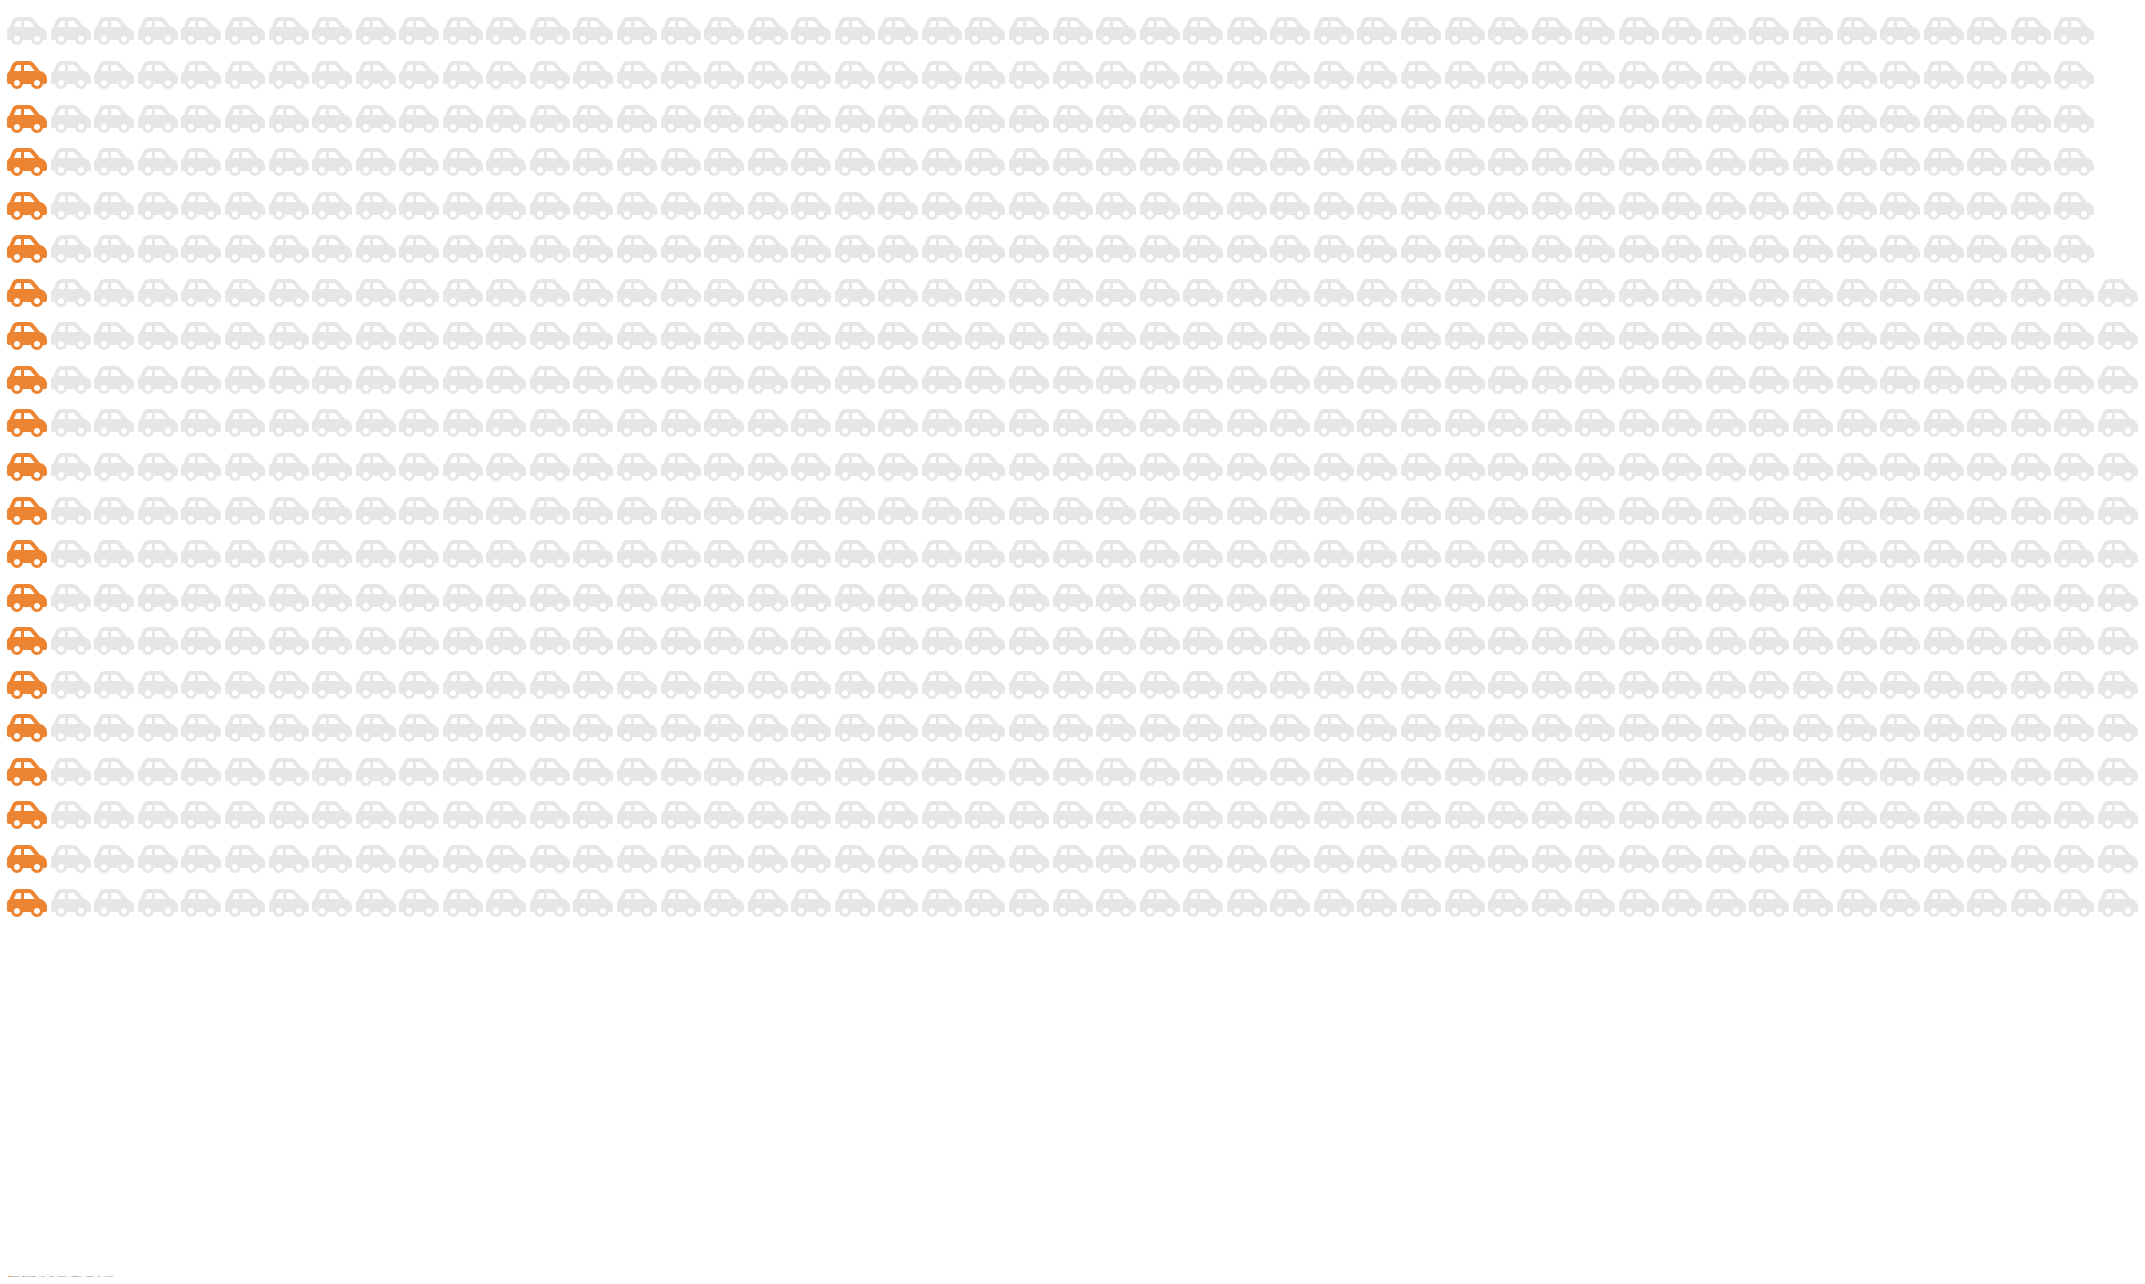

In [149]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=21,
    values=fuel.per_1000,
    labels=list(fuel.fuel),
    figsize=(30, 20),
    icons="car-side",
    colors=[
        "#ec8431",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
        "#e6e6e6",
    ],
    legend={
        "loc": "lower left",
        "bbox_to_anchor": (0, -0.4),
        "ncol": len(fuel),
        "framealpha": 0,
        "fontsize": 0,
    },
)

     |████████████████████████████████| 26.2 MB 4.7 MB/s            


See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)